<a href="https://colab.research.google.com/github/Le-Triumvirat/CADS-Internship/blob/main/Anomaly_detection_in_financial_services_using_knowledge_graphs_and_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Installing DGL and DGL-KE</h1>

> pip install dgl

> pip install dglke

In [1]:
import dgl
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# unique nodes are 34 and edge connections are 156 (might include either directed or undirected)
def build_karate_club_graph():
    # source node
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    # destination node
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # concatenating source and destination to form connections represented as directed, as DGL by default doesn't include directed.
    u = np.concatenate([src,dst])
    v = np.concatenate([dst,src])
    return dgl.graph((u,v))

Using backend: pytorch


In [2]:
g = build_karate_club_graph()
# g.ndata['features'] = torch.zeros(34,1)
# print(g)
# print(nx)
nx_g = g.to_networkx().to_undirected()
# print(type(nx_g))
'''A layout function for returning coordinates of edges'''
pos = nx.kamada_kawai_layout(nx_g)
# print(pos)

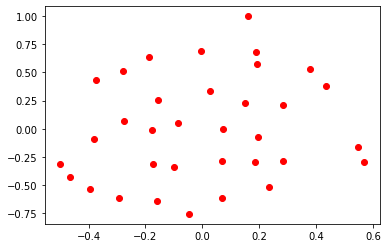

In [4]:
'''nothing interesting here'''
for i in range(34):
  plt.scatter(pos[i][0],pos[i][1],color='red')

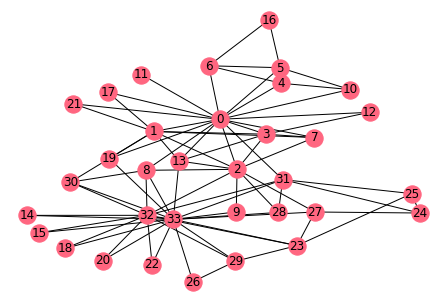

In [3]:
'''The real deal'''
nx.draw(nx_g, pos, with_labels=True, node_color=[[1,.4,.5]])

In [149]:
'''Creation of GCN starts'''

import torch
import torch.nn as nn
import torch.nn.functional as F

# a=torch.tensor([[1,2,3],[4,5,6]])
embed = nn.Embedding(34,5)
# print(embed(a))
# print(type(embed))
# print(embed.weight)
for i in embed.parameters():
    print(i)
# g.ndata['feat'] = embed.weight
# g.ndata['feat'][[0,1]]

Parameter containing:
tensor([[-0.2746, -1.6067, -1.0158,  1.1788,  0.3107],
        [ 0.2097, -0.9227, -1.6233, -0.5464, -1.3705],
        [ 0.2445,  1.7637, -0.6418, -0.9867, -0.0223],
        [-1.1622,  0.0565,  1.3254, -1.5244,  2.3536],
        [ 0.3782,  0.3152,  0.2372, -0.0654,  1.2724],
        [-2.0054,  1.0839, -0.6195,  0.3902,  1.2887],
        [-0.6430,  2.7920, -1.0365,  0.2286, -0.8022],
        [-0.1019, -1.9770,  0.0285, -0.0859,  1.4652],
        [ 0.0645, -0.3550, -1.2292, -0.2619, -0.0249],
        [-0.4134,  1.1644, -1.7083,  1.8039,  0.3529],
        [-0.8789,  0.4594,  0.4667,  1.2271, -1.0107],
        [ 1.0457, -0.6064,  0.2493,  0.0871,  0.4590],
        [-0.8210,  0.0594, -0.7532, -0.5012,  1.2816],
        [-2.3453, -1.7259, -1.3628,  0.1628,  0.4682],
        [-0.7393, -3.7303, -0.5067, -0.6764,  0.8712],
        [ 0.4182,  0.4102, -2.1670,  1.4497,  1.0649],
        [-0.1470, -0.7383,  0.0129,  0.5836,  0.5801],
        [ 0.6326, -0.1546,  1.0450, -0.0323

In [7]:
from dgl.nn.pytorch import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        # super(GCN, self).__init__()
        super().__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h
net = GCN(5, 5, 2)

In [8]:
inputs = embed.weight
# print(inputs.size())
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [9]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(g, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6507
Epoch 1 | Loss: 0.6288
Epoch 2 | Loss: 0.6068
Epoch 3 | Loss: 0.5842
Epoch 4 | Loss: 0.5616
Epoch 5 | Loss: 0.5388
Epoch 6 | Loss: 0.5154
Epoch 7 | Loss: 0.4912
Epoch 8 | Loss: 0.4669
Epoch 9 | Loss: 0.4428
Epoch 10 | Loss: 0.4183
Epoch 11 | Loss: 0.3929
Epoch 12 | Loss: 0.3672
Epoch 13 | Loss: 0.3412
Epoch 14 | Loss: 0.3158
Epoch 15 | Loss: 0.2914
Epoch 16 | Loss: 0.2677
Epoch 17 | Loss: 0.2444
Epoch 18 | Loss: 0.2220
Epoch 19 | Loss: 0.2005
Epoch 20 | Loss: 0.1796
Epoch 21 | Loss: 0.1602
Epoch 22 | Loss: 0.1421
Epoch 23 | Loss: 0.1252
Epoch 24 | Loss: 0.1099
Epoch 25 | Loss: 0.0960
Epoch 26 | Loss: 0.0836
Epoch 27 | Loss: 0.0726
Epoch 28 | Loss: 0.0629
Epoch 29 | Loss: 0.0544
Epoch 30 | Loss: 0.0470
Epoch 31 | Loss: 0.0407
Epoch 32 | Loss: 0.0352
Epoch 33 | Loss: 0.0306
Epoch 34 | Loss: 0.0266
Epoch 35 | Loss: 0.0232
Epoch 36 | Loss: 0.0203
Epoch 37 | Loss: 0.0178
Epoch 38 | Loss: 0.0157
Epoch 39 | Loss: 0.0139
Epoch 40 | Loss: 0.0123
Epoch 41 | Loss: 0.0110
Ep

In [10]:
print(f'Total epochs : {len(all_logits)}')
print(f'Size of each graph in an epoch : {all_logits[0].size()}')

# a=[1,2,3,4.5]
# max(a)

Total epochs : 50
Size of each graph in an epoch : torch.Size([34, 2])


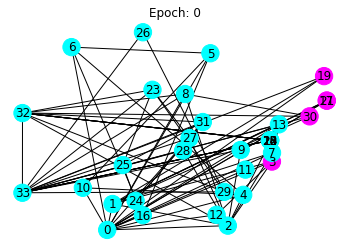

In [42]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline

def draw(i):
    '''Unique colors for node with feature 0 and 1'''
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    '''Feature embeddings are taken as coordinates or vice-versa. Its bidirectional, you know'''
    pos = {}
    '''Colors for every node is stored in a list for passing argument to networkx'''
    colors = []
    '''For every epoch(i), the feature embeddings are taken for the respective node.'''
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax() #argmax() returns the position of the max value present in the list. Either 0 or 1 in this case.
        colors.append(cls1color if cls else cls2color)
    ax.cla() #clears the axes
    ax.axis('off') #axes are set to off
    ax.set_title('Epoch: %d' % i)
    
#     nx.draw_networkx(nx_g.to_undirected(), pos, node_color=colors, with_labels=True, node_size=300, ax=ax)
    nx.draw(nx_g.to_undirected(), pos, node_color=colors, with_labels=True, node_size=300, ax=ax)

# fig = plt.figure(dpi=100)
fig = plt.figure() # by default, dpi is 100
fig.clf() # to clear the figure, just as a best practice
ax = fig.subplots() # single axis
draw(0)  # draw the prediction of the first epoch
# plt.close()

In [44]:
'''Not working.'''
ani = animation.FuncAnimation(fig, func=draw, frames=np.arange(0,len(all_logits)), interval=200)
plt.show()

<h1>DGL with CoraDataset</h1>

In [45]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F

In [49]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
print('Number of categories:', dataset.num_classes)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Number of categories: 7


In [61]:
g = dataset[0]
print('Node features')
print(f"Feature space dimension : {g.ndata['feat'].size()}")
print(g.ndata)
print('Edge features')
print(g.edata)

Node features
Feature space dimension : torch.Size([2708, 1433])
{'train_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}
Edge features
{}


In [65]:
from dgl.nn import GraphConv

class GCN_cora(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super().__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Create the model with given dimensions
model = GCN_cora(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In [102]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        '''CrossEntropyLoss is used as it is a categorical set.'''
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
train(g, model)

In epoch 0, loss: 1.945, val acc: 0.154 (best 0.154), test acc: 0.168 (best 0.168)
In epoch 10, loss: 1.787, val acc: 0.482 (best 0.518), test acc: 0.473 (best 0.533)
In epoch 20, loss: 1.545, val acc: 0.576 (best 0.576), test acc: 0.582 (best 0.582)
In epoch 30, loss: 1.244, val acc: 0.628 (best 0.628), test acc: 0.639 (best 0.639)
In epoch 40, loss: 0.925, val acc: 0.656 (best 0.658), test acc: 0.670 (best 0.663)
In epoch 50, loss: 0.646, val acc: 0.708 (best 0.708), test acc: 0.715 (best 0.715)
In epoch 60, loss: 0.435, val acc: 0.722 (best 0.722), test acc: 0.733 (best 0.733)
In epoch 70, loss: 0.291, val acc: 0.742 (best 0.742), test acc: 0.755 (best 0.755)
In epoch 80, loss: 0.197, val acc: 0.756 (best 0.756), test acc: 0.764 (best 0.764)
In epoch 90, loss: 0.138, val acc: 0.760 (best 0.762), test acc: 0.755 (best 0.755)


In [77]:
damn=model.parameters()
i=0
while(i<4):
    print(next(damn).size())
    i+=1

torch.Size([1433, 16])
torch.Size([16])
torch.Size([16, 7])
torch.Size([7])


In [101]:
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

logits = model(g, features)

# Compute prediction
pred = logits.argmax(1)
print(pred)
print(pred.size())
print(logits.size())
print(logits[0].argmax(0))

tensor([3, 4, 4,  ..., 3, 3, 3])
torch.Size([2708])
torch.Size([2708, 7])
tensor(3)


<h1>Knowledge graph</h1>
<p>Headline files:</p>
<ol>
    CNN
    <li>boeing.csv</li>
    <li>google.csv</li>
    <li>walmart.csv</li>
    <br>Reuters
    <li>apple.csv</li>
    <li>microsoft.csv</li>
    <li>samsung.csv</li>
</ol>

Headlines dataset are present in the directory "headlines"
To install pandas, perform the following command in the terminal

> **pip install pandas**


In [10]:
import pandas as pd

directory = './headlines/'
headline_filenames = ['boeing.csv','google.csv','walmart.csv','apple.csv','microsoft.csv','samsung.csv']
stock_filenames = {'apple':'AAPL.csv','boeing':'BA.csv','google':'GOOG.csv','microsoft':'MSFT.csv','samsung':'SSNLF.csv','walmart':'WMT.csv'}
companies = ['boeing','google','walmart','apple','microsoft','samsung']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# headline_filenames[0][:-4]

In [49]:
for i in filenames:
    a=pd.read_csv(directory+i)
    print(a.head(2))

        Date                                              Title
0  24-Feb-17  Trump rally: CEOs of Dow companies make $400 m...
1  24-Feb-17  Has my pilot had too much to drink? It depends...
        Date                                              Title
0  27-Feb-17  Historic Oscar victories for ESPN, Netflix and...
1  25-Feb-17  Apple, Microsoft, PayPal join legal fight for ...
        Date                                              Title
0  27-Feb-17  Ellen DeGeneres and Walmart give these student...
1  24-Feb-17  Trump rally: CEOs of Dow companies make $400 m...
              Date                                              Title
0  2011/10/18 0:00                 Apple iPhone 4S: Believe the hype?
1  2011/10/18 0:00  Tech wrap: Apple misses, Intel beats quarterly...
                 Date                                              Title
0  2011-10-26 0:00:00  Tech wrap: RIM delays tablet update, Nokia unv...
1  2011-11-01 0:00:00  Tech wrap: Yahoo finds interclick, pays $270 

Since Apple and Microsoft don't have headers in their csv files, the following code includes them. Just execute it once.

In [27]:
print('Original dataset of apple.csv')
apple=pd.read_csv(directory+'apple.csv')
print(apple.head(2))

Original dataset of apple.csv
   2011/10/17 0:00       Tech wrap: Apples Siri spurs iPhone 4S sales
0  2011/10/18 0:00                 Apple iPhone 4S: Believe the hype?
1  2011/10/18 0:00  Tech wrap: Apple misses, Intel beats quarterly...


In [31]:
print('Updated dataset of apple.csv')
apple.to_csv(directory+'apple.csv',header=["Date","Title"],index=False)
apple=pd.read_csv(directory+'apple.csv')
print(apple.head(2))

Updated dataset of apple.csv
              Date                                              Title
0  2011/10/18 0:00                 Apple iPhone 4S: Believe the hype?
1  2011/10/18 0:00  Tech wrap: Apple misses, Intel beats quarterly...


In [32]:
print('Original dataset of microsoft.csv')
microsoft=pd.read_csv(directory+'microsoft.csv')
print(microsoft.head(2))

Original dataset of microsoft.csv
   2011-10-20 0:00:00       Tech wrap: Basic phones lift Nokia to profit
0  2011-10-26 0:00:00  Tech wrap: RIM delays tablet update, Nokia unv...
1  2011-11-01 0:00:00  Tech wrap: Yahoo finds interclick, pays $270 m...


In [33]:
print('Updated dataset of microsoft.csv')
microsoft.to_csv(directory+'microsoft.csv',header=["Date","Title"],index=False)
microsoft=pd.read_csv(directory+'microsoft.csv')
print(microsoft.head(2))

Updated dataset of microsoft.csv
                 Date                                              Title
0  2011-10-26 0:00:00  Tech wrap: RIM delays tablet update, Nokia unv...
1  2011-11-01 0:00:00  Tech wrap: Yahoo finds interclick, pays $270 m...


<h3>Changing all the date category's format to yyyy/m/d and headlines to smallercase</h3>
1. Google <br>
2. Boeing <br>
3. Walmart <br>
4. Samsung <br>
5. Microsoft

In [24]:
'''
For Google, Boeing and Walmart
'''
def datePreProcess(company):
    df=pd.read_csv('./headlines/'+company+'.csv')
    df_len = len(df.index) # no of rows
    if(company in ['google','boeing','walmart']):
        for i in range(df_len):
            temp = df['Date'][i].split('-')
            temp[2] = '20'+temp[2]
            df['Date'][i] = temp[2]+'/'+str(months.index(temp[1])+1)+'/'+temp[0]
            df['Title'][i] = df['Title'][i].lower()
        df.to_csv('./headlines/Pre-processed/'+company+'.csv',header=["Date","Title"],index=False)
        
    if(company=='samsung'):
        for i in range(df_len):
            temp = df['Date'][i].split('-')
            if(temp[2][0]=='0'): # for day
                temp[2]=temp[2][-1]
            if(temp[1][0]=='0'): # for month
                temp[1]=temp[1][-1]
            df['Date'][i] = '/'.join(temp)
            df['Title'][i] = df['Title'][i].lower()
        df.to_csv('./headlines/Pre-processed/'+company+'.csv',header=["Date","Title"],index=False)
        
    if(company=='microsoft'):
        for i in range(df_len):
            temp = df['Date'][i][:-8].split('-')
            if(temp[2][0]=='0'):
                temp[2]=temp[2][-1]
            if(temp[1][0]=='0'): # for month
                temp[1]=temp[1][-1]
            df['Date'][i] = '/'.join(temp)
            df['Title'][i] = df['Title'][i].lower()
        df.to_csv('./headlines/Pre-processed/'+company+'.csv',header=["Date","Title"],index=False)
    
    if(company=='apple'):
        for i in range(df_len):
            df['Date'][i] = df['Date'][i][:-5]
            df['Title'][i] = df['Title'][i].lower()
        df.to_csv('./headlines/Pre-processed/'+company+'.csv',header=["Date","Title"],index=False)
    print(f'Successfully converted headlines to lowercase and updated the date format of {company}')

In [55]:
'''
Google headline date preprocessing
'''
datePreProcess('google')

Successfully converted headlines to lowercase and updated the date format of google


In [56]:
'''
Boeing headline date preprocessing
'''
datePreProcess('boeing')

Successfully converted headlines to lowercase and updated the date format of boeing


In [57]:
'''
Walmart headline date preprocessing
'''
datePreProcess('walmart')

Successfully converted headlines to lowercase and updated the date format of walmart


In [26]:
'''
Samsung headline date preprocessing
'''
datePreProcess('samsung')

Successfully converted headlines to lowercase and updated the date format of samsung


In [25]:
'''
Microsoft headline date preprocessing
'''
datePreProcess('microsoft')

Successfully converted headlines to lowercase and updated the date format of microsoft


In [60]:
'''
Apple headline date preprocessing
'''
datePreProcess('apple')

Successfully converted headlines to lowercase and updated the date format of apple


In [186]:
import pandas as pd
import dgl
import numpy as np
import networkx as nx

G = nx.Graph()

In [98]:
# colors=[]
# company_index=0
# for file in headline_filenames:
#     company_name = companies[company_index]
#     comp_news = pd.read_csv('./headlines/Pre-processed/'+file)
#     length = len(comp_news.index)
#     for index in range(length):
#         news = comp_news['Title'][index]
#         G.add_edges_from([(company_name,news)])
#         for comp in companies:
#             if comp in news:
#                 G.add_edges_from([(comp,news)])
#             else:
#                 continue
# #     print(length)
# nx.draw(G,with_labels=True)

KeyboardInterrupt: 

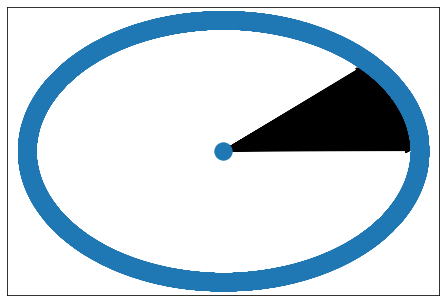

In [86]:
'''
Google KG complete
'''
Google_G = nx.Graph()
Google_G.add_node('Google')
Google = pd.read_csv('./headlines/Pre-processed/google.csv')
length_google = len(Google.index)

for i in range(length_google):
    Google_G.add_edges_from([('Google',Google['Title'][i])])
pos = nx.kamada_kawai_layout(Google_G)
nx.draw(Google_G,pos,with_labels=False)
# 1,7,2,3,

In [235]:
'''
Google KG minimal
'''
Google_G_min = nx.DiGraph()
Google_G_min.add_node('Google')
Google = pd.read_csv('./headlines/Pre-processed/google.csv')
Google_stock = pd.read_csv('./Stock Price/GOOG.csv')

# length_google = len(Google.index)
colors=['red']
for i in range(10):
#     stock_value = str(Google_stock.loc[Google_stock['Date']==Google['Date'][i]]['Close'])
    stock_value = Google_stock[Google_stock.eq(Google['Date'][i]).any(1)].to_numpy()[0][4]
#     print(stock_value if stock_value else print('no'))
    print(stock_value)
    
#     Google_G_min.add_edge('Google',Google['Title'][i])
#     Google_G_min.add_edge(Google['Title'][i],Google['Date'][i])
#     Google_G_min.add_edge(Google['Date'][i],'Google')
    
#     Google_G_min.add_edge(Google['Date'][i],stock_value)

# pos = nx.kamada_kawai_layout(Google_G_min)
pos = nx.random_layout(Google_G_min,center=None,dim=2)
# nx.draw(Google_G_min,pos,with_labels=True,node_color='orange')
nx.draw(Google_G_min,pos,with_labels=True,node_color='orange')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [197]:
stock_value = Google_stock.loc[Google_stock['Date']==Google['Date'][4]]['Close'].iloc[0]
stock_value
type(stock_value)

# 2017/2/23
Google_stock['Date']=='2017/2/23'

TypeError: index() takes at least 1 argument (0 given)

831.330017

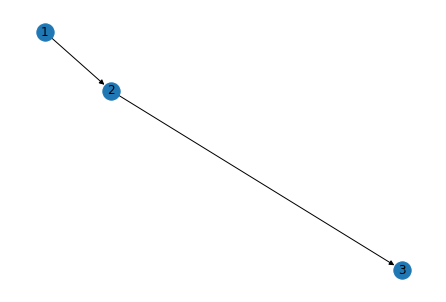

In [234]:
# GG = nx.lollipop_graph(4, 10)
GG = nx.DiGraph()
GG.add_edges_from([(1,2,{'close':'yep'})])
GG.add_edge(2,3)
pos = nx.random_layout(GG,center=None,dim=2)
nx.draw(GG,pos,with_labels=True)

a=Google_stock[Google_stock.eq('2017/2/23').any(1)].to_numpy()[0][4]
# b=a.to_numpy()
# b[0][4]
a
# print(a['Close'].value())

In [8]:
'''
KDJ  |  W%R  |  RSI
'''
import pandas as pd
goog = pd.read_csv('Stock Price\GOOG.csv')
print(f"KDJ (Min and Max) {goog['KDJ'].min()}\t {goog['KDJ'].max()}")
print(f"W%R (Min and Max) {goog['W%R'].min()}\t {goog['W%R'].max()}")
print(f"RSI (Min and Max) {goog['RSI'].min()}\t {goog['RSI'].max()}")
row_count = len(goog)
'''
Labels
0 - overbought > 0.8 (sell)
1 - oversold < 0.2 (buy)
2 - nil trend [0.2,0.8]
Note : Only AAPL has a column called as label
'''
# goog['KDJ'].sum()/len(goog['KDJ'].index)
# goog['KDJ'].max()
print('')

KDJ (Min and Max) 0.0	 1.0
W%R (Min and Max) -1.0	 0.0
RSI (Min and Max) -92.080017	 41.369995



<h4>KDJ | W%R</h4>
If it is between 20 and 80 the market is neutral, if it is above 80 it is bullish/overbought and if it is below 20 it is bearish/oversold. If it is below 0 or above 100 it is very bearish or very bullish, but also very-oversold and very-overbought.

Overbought --> overvalued that its intrinsic(bullish)<br>
Oversold --> undervalued that its intrinsic(bearish)

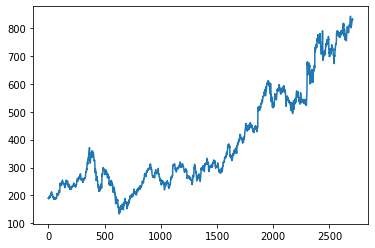

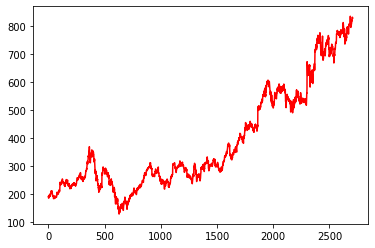

In [2]:
import matplotlib.pyplot as plt

plt.plot(goog['High'])
plt.show()
plt.plot(goog['Close'],color='red')
plt.show()

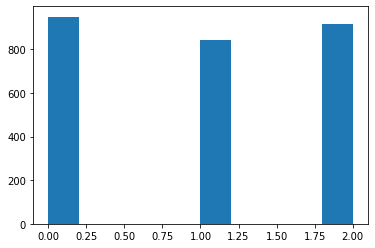

In [3]:
label=[]
for i in range(row_count):
    if(goog['KDJ'][i] < 0.2):
        label.append(1)
    elif(goog['KDJ'][i] > 0.8):
        label.append(0)
    else:
        status = ((goog['Close'][i]-goog['Open'][i])/goog['Open'][i])*100
        if(status < -0.66):
            label.append(0)
        elif(status > 0.66):
            label.append(1)
        else:
            label.append(2)
# print(label)
plt.hist(label)
plt.show()

In [4]:
print(label.count(0))
print(label.count(1))
print(label.count(2))

950
841
916


x<20...80<x
$100
(+$70)
$30
((closing-opening)/(opening))*100
<-0.75 sell
>0.75 buy

In [7]:
goog['Label']=label
goog

,Date,Open,High,Low,Close,Volume,KDJ,W%R,RSI,Label
0,2006/5/25,188.315186,190.262527,184.952072,190.257553,16495700,0.999063,-0.000937,0.000000,0
1,2006/5/26,191.032516,191.693222,188.787125,189.442856,7381600,0.225640,-0.774360,1.814697,0
2,2006/5/30,187.917770,189.268982,184.524841,184.768265,8688100,0.051310,-0.948690,5.674591,1
3,2006/5/31,185.692245,187.902878,182.204926,184.708649,16066300,0.439408,-0.560592,1.059616,2
4,2006/6/1,185.563095,190.257553,184.599365,190.073761,12637600,0.967518,-0.032482,-4.365112,0
...,...,...,...,...,...,...,...,...,...,...
2702,2017/2/17,823.020020,828.070007,821.655029,828.070007,1611000,1.000000,0.000000,-2.910034,0
2703,2017/2/21,828.659973,833.450012,828.349976,831.659973,1262300,0.649014,-0.350986,-2.589966,2
2704,2017/2/22,828.659973,833.250000,828.640015,830.760010,982900,0.459870,-0.540130,1.899963,2
2705,2017/2/23,830.119995,832.460022,822.880005,831.330017,1472800,0.882046,-0.117954,0.429993,0


In [8]:
goog.to_csv('goog_labeled.csv',index=False)
print('woah')
# df.to_csv('./headlines/Pre-processed/'+company+'.csv',header=["Date","Title"],index=False)

woah


In [1]:
'''
TF-IDF trial
'''
import pandas as pd
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

googH = pd.read_csv('./headlines/Pre-processed/google.csv')
type(googH['Title'])
headlines_list=googH['Title'].values.tolist()
len(headlines_list)

5277

In [19]:
tfIdfVectorizer=TfidfVectorizer(analyzer='word', use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(headlines_list)
print(tfIdf[0].shape)
print(type(tfIdf))
# print(tfIdf[0].todense())
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
# df = df.sort_values('TF-IDF', ascending=False)
df
# [0:{'word':'value'}]
# df.to_csv('./TFIDF'+'.csv',header=["TF-IDF"],index=True)

(1, 5772)
<class 'scipy.sparse.csr.csr_matrix'>


,TF-IDF
000,0.0
005,0.0
06,0.0
07,0.0
08,0.0
...,...
zuck,0.0
zuckerberg,0.0
zucks,0.0
zune,0.0


# Rough work

In [63]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    'Hardest choice in the lives requires the strongest wills',
    'When I am done, half of humanity will still exist. And I hope they remember you',
    'Little one, its a simple calculus. This universe is finite, its resources finite. If life is left unchecked, life will cease to exist. It needs correction.',
    'I used the stones to destroy the stones. It nearly killed me, but the work is done. It always will be. I am...inevitable'
]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(X[1])
X
print(vectorizer.get_feature_names())
# print(len(vectorizer.get_feature_names()))

  (0, 51)	0.2854558802199217
  (0, 33)	0.2854558802199217
  (0, 41)	0.2854558802199217
  (0, 15)	0.2854558802199217
  (0, 2)	0.2854558802199217
  (0, 11)	0.2250566947475355
  (0, 37)	0.2854558802199217
  (0, 48)	0.18220279066644673
  (0, 16)	0.2854558802199217
  (0, 31)	0.2854558802199217
  (0, 13)	0.2854558802199217
  (0, 10)	0.2250566947475355
  (0, 1)	0.2250566947475355
  (0, 47)	0.2854558802199217
['always', 'am', 'and', 'be', 'but', 'calculus', 'cease', 'choice', 'correction', 'destroy', 'done', 'exist', 'finite', 'half', 'hardest', 'hope', 'humanity', 'if', 'in', 'inevitable', 'is', 'it', 'its', 'killed', 'left', 'life', 'little', 'lives', 'me', 'nearly', 'needs', 'of', 'one', 'remember', 'requires', 'resources', 'simple', 'still', 'stones', 'strongest', 'the', 'they', 'this', 'to', 'unchecked', 'universe', 'used', 'when', 'will', 'wills', 'work', 'you']


In [28]:
vectorizer1 = TfidfVectorizer(analyzer='word', stop_words='english', use_idf=True)
X = vectorizer1.fit_transform(corpus)
# print(X)
print(vectorizer1.get_feature_names())
print(len(vectorizer1.get_feature_names()))

['calculus', 'cease', 'choice', 'correction', 'destroy', 'exist', 'finite', 'half', 'hardest', 'hope', 'humanity', 'inevitable', 'killed', 'left', 'life', 'little', 'lives', 'nearly', 'needs', 'remember', 'requires', 'resources', 'simple', 'stones', 'strongest', 'unchecked', 'universe', 'used', 'wills', 'work']
30


In [21]:
[headlines_list[:10]]

[['historic oscar victories for espn, netflix and amazon',
  'apple, microsoft, paypal join legal fight for transgender rights',
  "why you shouldn't freak out (yet) about the 'cloudbleed' security leak",
  "google's waymo sues uber over self-driving car technology",
  'tech criticizes trump on transgender reversal',
  'google commits $11.5 million to racial justice efforts',
  'lyft expands into 54 new cities, while uber does damage control',
  'apple criticizes trump over reversal of transgender bathroom guidelines',
  'these 10 stocks dominate the market',
  "russia accuses western media of spreading 'fake news'"]]

In [27]:
vectorizer2 = TfidfVectorizer(analyzer='word', stop_words='english', use_idf=True)
X = vectorizer2.fit_transform([headlines_list[7]])
print(X)
# print(X.shape)
print(vectorizer2.get_feature_names())
# print(len(vectorizer2.get_feature_names()))
# X.shape # --> (documents,features). Features are unique words in a single document

  (0, 3)	0.3779644730092272
  (0, 1)	0.3779644730092272
  (0, 5)	0.3779644730092272
  (0, 4)	0.3779644730092272
  (0, 6)	0.3779644730092272
  (0, 2)	0.3779644730092272
  (0, 0)	0.3779644730092272
['apple', 'bathroom', 'criticizes', 'guidelines', 'reversal', 'transgender', 'trump']


In [7]:
import dgl
import numpy as np
import torch as th
from dgl.nn import RelGraphConv
g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))
feat = th.ones(6, 10)
conv = RelGraphConv(10, 2, 3, regularizer='basis', num_bases=2)
conv.weight.shape
etype = th.tensor(np.array([0,1,2,0,1,2]).astype(np.int64))
res = conv(g, feat, etype)

torch.Size([2, 10, 2])

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
goog_lab = pd.read_csv('goog_labeled.csv')
goog_lab

,Date,Open,High,Low,Close,Volume,KDJ,W%R,RSI,Label
0,2006/5/25,188.315186,190.262527,184.952072,190.257553,16495700,0.999063,-0.000937,0.000000,0
1,2006/5/26,191.032516,191.693222,188.787125,189.442856,7381600,0.225640,-0.774360,1.814697,0
2,2006/5/30,187.917770,189.268982,184.524841,184.768265,8688100,0.051310,-0.948690,5.674591,1
3,2006/5/31,185.692245,187.902878,182.204926,184.708649,16066300,0.439408,-0.560592,1.059616,2
4,2006/6/1,185.563095,190.257553,184.599365,190.073761,12637600,0.967518,-0.032482,-4.365112,0
...,...,...,...,...,...,...,...,...,...,...
2702,2017/2/17,823.020020,828.070007,821.655029,828.070007,1611000,1.000000,0.000000,-2.910034,0
2703,2017/2/21,828.659973,833.450012,828.349976,831.659973,1262300,0.649014,-0.350986,-2.589966,2
2704,2017/2/22,828.659973,833.250000,828.640015,830.760010,982900,0.459870,-0.540130,1.899963,2
2705,2017/2/23,830.119995,832.460022,822.880005,831.330017,1472800,0.882046,-0.117954,0.429993,0


In [2]:
# [Jan,Feb,March]
# (1,2,3)

# [April,May,Jun]
# (4,5,6)

# [Jul,Aug,Sep]
# (7,8,9)

# [Oct,Nov,Dec]
# (10,11,12)

# Connect graphs based on these relationships [Quarter-wise]
first_quarter = ('1','2','3')
second_quarter = ('4','5','6')
third_quarter = ('7','8','9')
fourth_quarter = ('10','11','12')

list_of_years = []
num_of_rows = len(goog_lab.index)
# pd.unique(goog_lab['Date'])
for i in range(num_of_rows):
    if goog_lab['Date'][i][:4] not in list_of_years:
        list_of_years.append(goog_lab['Date'][i][:4])
    else:
        continue
list_of_years
# goog_lab['Date'][0][:4]=='2006'

['2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017']

In [3]:
import networkx as nx
goog_graph = nx.Graph()

'''
adding label edges 0,1,2 to the graph
'''
goog_graph.add_nodes_from(['0','1','2'])

In [4]:
for i in range(num_of_rows-1):
    if (goog_lab['Date'][i][5:6] in first_quarter) and (goog_lab['Date'][i+1][5:6] in first_quarter):
        goog_graph.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
    
    elif (goog_lab['Date'][i][5:6] in second_quarter) and (goog_lab['Date'][i+1][5:6] in second_quarter):
        goog_graph.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
        
    elif (goog_lab['Date'][i][5:6] in third_quarter) and (goog_lab['Date'][i+1][5:6] in third_quarter):
        goog_graph.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
        
    elif (goog_lab['Date'][i][5:6] in fourth_quarter) and (goog_lab['Date'][i+1][5:6] in fourth_quarter):
        goog_graph.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
    
    else:
        continue
    goog_graph.add_edges_from( [ ( goog_lab['Date'][i] , str(goog_lab['Label'][i]) ) ] )

goog_graph.add_edges_from( [ ( goog_lab['Date'][num_of_rows-1] , str(goog_lab['Label'][num_of_rows-1]) ) ] )

# goog_graph.add_edges_from([(1,2)])

# pos = nx.kamada_kawai_layout(goog_graph)
# nx.draw(goog_graph,pos,with_labels=False)

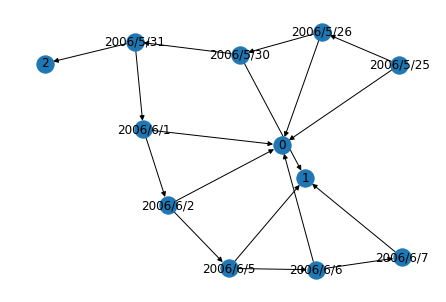

In [42]:
import networkx as nx
import matplotlib.pyplot as plt

goog_graph_1 = nx.DiGraph()

for i in range(8):
    if (goog_lab['Date'][i][5:6] in first_quarter) and (goog_lab['Date'][i+1][5:6] in first_quarter):
        goog_graph_1.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
    
    elif (goog_lab['Date'][i][5:6] in second_quarter) and (goog_lab['Date'][i+1][5:6] in second_quarter):
        goog_graph_1.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
        
    elif (goog_lab['Date'][i][5:6] in third_quarter) and (goog_lab['Date'][i+1][5:6] in third_quarter):
        goog_graph_1.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
        
    elif (goog_lab['Date'][i][5:6] in fourth_quarter) and (goog_lab['Date'][i+1][5:6] in fourth_quarter):
        goog_graph_1.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
    
    else:
        continue
    goog_graph_1.add_edges_from( [ ( goog_lab['Date'][i] , str(goog_lab['Label'][i] ) ) ] )

goog_graph_1.add_edges_from( [ ( goog_lab['Date'][8] , str(goog_lab['Label'][8]) ) ] )

# goog_graph.add_edges_from([(1,2)])
pos = nx.kamada_kawai_layout(goog_graph_1)
nx.draw(goog_graph_1,pos,with_labels=True)

In [12]:
goog_lab.iloc[2]
goog_lab

,Date,Open,High,Low,Close,Volume,KDJ,W%R,RSI,Label
0,2006/5/25,188.315186,190.262527,184.952072,190.257553,16495700,0.999063,-0.000937,0.000000,0
1,2006/5/26,191.032516,191.693222,188.787125,189.442856,7381600,0.225640,-0.774360,1.814697,0
2,2006/5/30,187.917770,189.268982,184.524841,184.768265,8688100,0.051310,-0.948690,5.674591,1
3,2006/5/31,185.692245,187.902878,182.204926,184.708649,16066300,0.439408,-0.560592,1.059616,2
4,2006/6/1,185.563095,190.257553,184.599365,190.073761,12637600,0.967518,-0.032482,-4.365112,0
...,...,...,...,...,...,...,...,...,...,...
2702,2017/2/17,823.020020,828.070007,821.655029,828.070007,1611000,1.000000,0.000000,-2.910034,0
2703,2017/2/21,828.659973,833.450012,828.349976,831.659973,1262300,0.649014,-0.350986,-2.589966,2
2704,2017/2/22,828.659973,833.250000,828.640015,830.760010,982900,0.459870,-0.540130,1.899963,2
2705,2017/2/23,830.119995,832.460022,822.880005,831.330017,1472800,0.882046,-0.117954,0.429993,0


In [13]:
'''
Prepping the feature tensor matrix
'''
# 2707 x 8 --> feature tensor size
import torch
'''

[
    ['Open', 'High', 'Low', 'Close', 'Volume', 'KDJ', 'W%R', 'RSI'],
    [],
    .
    .
    .
    []
]

'''
print(list(goog_lab.columns[1:9]))
feature_set_=[]
feature_set_.append(list(goog_lab.iloc[0,1:9])) # for label 0
feature_set_.append(list(goog_lab.iloc[2,1:9])) # for label 1
feature_set_.append(list(goog_lab.iloc[3,1:9])) # for label 2
# num_of_rows
for i in range(num_of_rows):
    feature_set_.append(list(goog_lab.iloc[i,1:9]))
# feature_set = torch.tensor(feature_set,requires_grad=True)
feature_set = torch.tensor(feature_set_,dtype=torch.double)
print(feature_set.size())
feature_set = feature_set.double()
print(feature_set)

['Open', 'High', 'Low', 'Close', 'Volume', 'KDJ', 'W%R', 'RSI']
torch.Size([2710, 8])
tensor([[ 1.8832e+02,  1.9026e+02,  1.8495e+02,  ...,  9.9906e-01,
         -9.3664e-04,  0.0000e+00],
        [ 1.8792e+02,  1.8927e+02,  1.8452e+02,  ...,  5.1310e-02,
         -9.4869e-01,  5.6746e+00],
        [ 1.8569e+02,  1.8790e+02,  1.8220e+02,  ...,  4.3941e-01,
         -5.6059e-01,  1.0596e+00],
        ...,
        [ 8.2866e+02,  8.3325e+02,  8.2864e+02,  ...,  4.5987e-01,
         -5.4013e-01,  1.9000e+00],
        [ 8.3012e+02,  8.3246e+02,  8.2288e+02,  ...,  8.8205e-01,
         -1.1795e-01,  4.2999e-01],
        [ 8.2773e+02,  8.2900e+02,  8.2420e+02,  ...,  9.2500e-01,
         -7.4997e-02,  3.6900e+00]], dtype=torch.float64)


In [27]:
# lis = [0,1,2]
goog_lab_tensor_ = list(goog_lab['Label'])
goog_lab_tensor = list(goog_lab['Label'])

goog_lab_tensor.insert(0,0)
goog_lab_tensor.insert(1,1)
goog_lab_tensor.insert(2,2)

goog_lab_tensor = torch.tensor(goog_lab_tensor)
print(goog_lab_tensor.size())
print(goog_lab_tensor.resize(2710,1))

torch.Size([2710])
tensor([[0],
        [1],
        [2],
        ...,
        [2],
        [0],
        [0]])


torch.Size( [ 2710 ] )

1 x 2710 x 3

In [40]:
goog_lab_tensor__ = list(goog_lab['Label'])
goog_lab_tensor__.insert(0,0)
goog_lab_tensor__.insert(1,1)
goog_lab_tensor__.insert(2,2)
print(len(goog_lab_tensor__))

goog_lab_tensor_prob = []

for i in goog_lab_tensor__:
    if(i==0):
        goog_lab_tensor_prob.append([1,0,0])
    if(i==1):
        goog_lab_tensor_prob.append([0,1,0])
    if(i==2):
        goog_lab_tensor_prob.append([0,0,1])

print(goog_lab_tensor_prob[0:2])

2710
[[1, 0, 0], [0, 1, 0]]


In [43]:
goog_lab_tensor_prob = torch.tensor(goog_lab_tensor_prob)
print(type(goog_lab_tensor_prob))
print(goog_lab_tensor_prob)
print(goog_lab_tensor_prob.size())

<class 'torch.Tensor'>
tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        ...,
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0]])
torch.Size([2710, 3])


C:\Users\VISHNU~1\AppData\Local\Temp/ipykernel_12220/206955873.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goog_lab_tensor_prob = torch.tensor(goog_lab_tensor_prob)


In [28]:
# goog_lab_tensor__ = list(goog_lab['Label'])
# goog_lab_tensor__.insert(0,0)
# goog_lab_tensor__.insert(1,1)
# goog_lab_tensor__.insert(2,2)
# goog_lab_tensor__

picture
20 classes
[dog, cat, buffalo...]

[1,0,0,0,0...]

20 o/p 

In [17]:
# goog_lab_tensor_.append(1)
# len(goog_lab_tensor_)

[0]

In [29]:
len(goog_lab_tensor_)

goog_lab_tensor_ = torch.tensor(goog_lab_tensor_)
print(goog_lab_tensor_.size())
print(goog_lab_tensor_.resize(2708,1))

torch.Size([2708])
tensor([[0],
        [0],
        [1],
        ...,
        [0],
        [0],
        [1]])


In [58]:
feature_set.double()

tensor([[ 1.8832e+02,  1.9026e+02,  1.8495e+02,  ...,  9.9906e-01,
         -9.3664e-04,  0.0000e+00],
        [ 1.8792e+02,  1.8927e+02,  1.8452e+02,  ...,  5.1310e-02,
         -9.4869e-01,  5.6746e+00],
        [ 1.8569e+02,  1.8790e+02,  1.8220e+02,  ...,  4.3941e-01,
         -5.6059e-01,  1.0596e+00],
        ...,
        [ 8.2866e+02,  8.3325e+02,  8.2864e+02,  ...,  4.5987e-01,
         -5.4013e-01,  1.9000e+00],
        [ 8.3012e+02,  8.3246e+02,  8.2288e+02,  ...,  8.8205e-01,
         -1.1795e-01,  4.2999e-01],
        [ 8.2773e+02,  8.2900e+02,  8.2420e+02,  ...,  9.2500e-01,
         -7.4997e-02,  3.6900e+00]], dtype=torch.float64)

In [62]:
# 8 -> 6 -> 3

'''Creation of GCN starts'''

import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
import dgl

# print('gpu') if torch.cuda.is_available else print('cpu')
goog_graph_dgl = dgl.from_networkx(goog_graph)
# print(goog_graph_dgl.num_edges())
goog_graph_dgl.ndata['feature'] = feature_set
# print(goog_graph_dgl)
goog_graph_dgl.ndata['feature'][[0,1]]
print(goog_graph_dgl.ndata['feature'].shape[1])
print(goog_graph_dgl.ndata['feature'].shape[0])

8
2710


In [73]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        # super(GCN, self).__init__()
        super().__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, goog_graph_dgl, inputs):
        h = self.conv1(goog_graph_dgl, inputs)
        h = torch.relu(h)
        h = self.conv2(goog_graph_dgl, h)
        return h
net = GCN(goog_graph_dgl.ndata['feature'].shape[1], 6, 3)
net.double()

# norm='both', weight=True, bias=True
# 0 , 1 , 2

GCN(
  (conv1): GraphConv(in=8, out=6, normalization=both, activation=None)
  (conv2): GraphConv(in=6, out=3, normalization=both, activation=None)
)

In [93]:
# inputs = embed.weight
# # print(inputs.size())
# labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
# labels = torch.tensor([0, 1])  # their labels are different
output = net(goog_graph_dgl, feature_set)
print(output)

tensor([[-22890775.4365,   4934333.2902,    997770.6543],
        [-22096813.6048,   4763208.4644,    963228.4653],
        [-21024212.6512,   4531944.9826,    916292.4078],
        ...,
        [  -774657.8670,    166959.5714,     33680.1648],
        [  -799499.8366,    172314.1058,     34765.6054],
        [  -845482.5622,    182228.1726,     36772.4979]], dtype=torch.float64,
       grad_fn=<AddBackward0>)


In [94]:
output_ = output.detach()
print(output_)
output__ = F.softmax(output_,dim=1)
print(output__)

tensor([[-22890775.4365,   4934333.2902,    997770.6543],
        [-22096813.6048,   4763208.4644,    963228.4653],
        [-21024212.6512,   4531944.9826,    916292.4078],
        ...,
        [  -774657.8670,    166959.5714,     33680.1648],
        [  -799499.8366,    172314.1058,     34765.6054],
        [  -845482.5622,    182228.1726,     36772.4979]], dtype=torch.float64)
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], dtype=torch.float64)


In [103]:
a = torch.tensor([[-22890775.4365,   4934333.2902,    997770.6543]])
F.softmax(a,dim=1)

tensor([[0., 1., 0.]])

In [92]:
# input = torch.tensor([
#     [ 1.2699,  0.4911,  1.3784],
#     [-1.0419,  0.6298, -0.0393]
# ]
# )
# print(input)
# output = F.softmax(input,dim=1)
# print(output)

In [41]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), feature_set), lr=0.01)
all_logits = []
logp_ = 0
logits_ = 0
for epoch in range(30):
    logits = net(goog_graph_dgl, feature_set)
    # we save the logits for visualization later
    logits_ = logits
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    logp_ = logp
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp, goog_lab_tensor)
#     acc = (logp == goog_lab_tensor).float().mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))
#     print(f'Epoch {epoch} | Loss : {loss.item()} | Acc : {acc}')

Epoch 0 | Loss: 1574300.4861
Epoch 1 | Loss: 1503649.9075
Epoch 2 | Loss: 1434666.4790
Epoch 3 | Loss: 1367377.8096
Epoch 4 | Loss: 1301809.4446
Epoch 5 | Loss: 1237984.7091
Epoch 6 | Loss: 1175924.5601
Epoch 7 | Loss: 1115647.4469
Epoch 8 | Loss: 1057169.1825
Epoch 9 | Loss: 1000502.8254
Epoch 10 | Loss: 945658.5746
Epoch 11 | Loss: 892643.6778
Epoch 12 | Loss: 841462.3539
Epoch 13 | Loss: 792115.7308
Epoch 14 | Loss: 744601.7987
Epoch 15 | Loss: 698915.3802
Epoch 16 | Loss: 655048.1161
Epoch 17 | Loss: 612988.4690
Epoch 18 | Loss: 572721.7433
Epoch 19 | Loss: 534230.1227
Epoch 20 | Loss: 497492.7236
Epoch 21 | Loss: 462485.6661
Epoch 22 | Loss: 429182.1600
Epoch 23 | Loss: 397552.6076
Epoch 24 | Loss: 367564.7201
Epoch 25 | Loss: 339183.6488
Epoch 26 | Loss: 312372.1300
Epoch 27 | Loss: 287090.6414
Epoch 28 | Loss: 263297.5699
Epoch 29 | Loss: 240949.3900
Epoch 30 | Loss: 220000.8508
Epoch 31 | Loss: 200405.1700
Epoch 32 | Loss: 182114.2350
Epoch 33 | Loss: 165078.8080
Epoch 34 | Los

In [44]:
# logp_.size()
F.log_softmax(logits_,1)
# logits_
net.state_dict()

OrderedDict([('conv1.weight',
              tensor([[ 2.6295e-01,  3.8820e-01, -4.4232e-01,  1.0165e-01,  5.7747e-01,
                       -4.8948e-01],
                      [-8.1787e-02, -3.5873e-01,  5.9474e-01, -3.6470e-01, -5.1910e-01,
                       -9.3008e-01],
                      [-5.6239e-02, -1.6007e-01, -3.8832e-01,  1.8934e-01, -1.3270e-01,
                       -3.7349e-01],
                      [-2.2281e-01, -3.0784e-01, -2.1166e-01, -3.1473e-01, -2.2297e-02,
                       -1.7873e-01],
                      [-3.8162e-01, -5.4080e-01, -5.2070e-01, -4.9603e-01, -5.9959e-01,
                       -5.7324e-02],
                      [-5.4711e-01, -6.2048e-04,  3.6672e-01,  6.3872e-01, -6.3949e-01,
                       -3.9843e-01],
                      [ 4.3833e-01, -5.2642e-01,  4.7122e-01, -8.9306e-02, -2.4470e-01,
                        2.9664e-02],
                      [ 3.5006e-01, -2.3337e-01, -3.6553e-02, -4.2892e-04,  2.3031e-01,
       

In [45]:
net.state_dict()

Graph(num_nodes=2707, num_edges=5348,
      ndata_schemes={'feature': Scheme(shape=(8,), dtype=torch.float64)}
      edata_schemes={})

In [109]:
goog_graph.add_edges_from( [ ( goog_lab['Date'][2706] , '2017/2/25' ) ] )

# goog_graph_dgl = dgl.add_edges(goog_graph_dgl, )

# goog_lab['Date'][2706]
ba_lab = pd.read_csv('Stock Price\BA.csv')
# msft_lab.iloc[0,1:9]
feature_set_.append(list(ba_lab.iloc[0,1:9]))
feature_set = torch.tensor(feature_set_,dtype=torch.double)
feature_set

tensor([[ 1.8832e+02,  1.9026e+02,  1.8495e+02,  ...,  9.9906e-01,
         -9.3664e-04,  0.0000e+00],
        [ 1.9103e+02,  1.9169e+02,  1.8879e+02,  ...,  2.2564e-01,
         -7.7436e-01,  1.8147e+00],
        [ 1.8792e+02,  1.8927e+02,  1.8452e+02,  ...,  5.1310e-02,
         -9.4869e-01,  5.6746e+00],
        ...,
        [ 8.3012e+02,  8.3246e+02,  8.2288e+02,  ...,  8.8205e-01,
         -1.1795e-01,  4.2999e-01],
        [ 8.2773e+02,  8.2900e+02,  8.2420e+02,  ...,  9.2500e-01,
         -7.4997e-02,  3.6900e+00],
        [ 3.5500e+01,  3.7750e+01,  3.5500e+01,  ...,  3.0556e-01,
          6.9444e-01,  0.0000e+00]], dtype=torch.float64)

In [115]:
# type(feature_set_[2707][-1])
# ba_lab.iloc[0,1:9]
# ba_lab['RSI']
# feature_set.shape
goog_graph_dgl = dgl.from_networkx(goog_graph, device='cpu')
goog_graph_dgl
# feature_set_[2707]

Graph(num_nodes=2708, num_edges=5350,
      ndata_schemes={}
      edata_schemes={})

In [133]:
# net(goog_graph_dgl,feature_set)

logits = net(goog_graph_dgl, feature_set)
# we save the logits for visualization later
logits_ = logits
all_logits.append(logits.detach())
logp = F.log_softmax(logits, 1)
logp_ = logp
# we only compute loss for labeled nodes
loss = F.nll_loss(logp, goog_lab_tensor_)
print(loss)

tensor(1.0974, dtype=torch.float64, grad_fn=<NllLossBackward>)


In [151]:
# print(logits[2707])
ll = F.softmax(logits, 1)
print(ll[[1,2,3]])
print(ll.max(1))

tensor([[0.3536, 0.3051, 0.3414],
        [0.3536, 0.3051, 0.3414],
        [0.3536, 0.3051, 0.3414]], dtype=torch.float64,
       grad_fn=<IndexBackward>)
torch.return_types.max(
values=tensor([0.3536, 0.3536, 0.3536,  ..., 0.3536, 0.3536, 0.3536],
       dtype=torch.float64, grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0,  ..., 0, 0, 0]))


In [215]:
# print(f'Total epochs : {len(all_logits)}')
# print(f'Size of each graph in an epoch : {all_logits[0].size()}')

# a=[1,2,3,4.5]
# max(a)
test = torch.tensor([list(msft.iloc[0,1:8])])
msft = pd.read_csv('Stock Price\MSFT.csv')
# msft
# print(test)
logits_test = net(goog_graph_dgl, test)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2707x7 and 8x6)

In [206]:
goog_lab.iloc[:,1:9]

,Open,High,Low,Close,Volume,KDJ,W%R,RSI
0,188.315186,190.262527,184.952072,190.257553,16495700,0.999063,-0.000937,0.000000
1,191.032516,191.693222,188.787125,189.442856,7381600,0.225640,-0.774360,1.814697
2,187.917770,189.268982,184.524841,184.768265,8688100,0.051310,-0.948690,5.674591
3,185.692245,187.902878,182.204926,184.708649,16066300,0.439408,-0.560592,1.059616
4,185.563095,190.257553,184.599365,190.073761,12637600,0.967518,-0.032482,-4.365112
...,...,...,...,...,...,...,...,...
2702,823.020020,828.070007,821.655029,828.070007,1611000,1.000000,0.000000,-2.910034
2703,828.659973,833.450012,828.349976,831.659973,1262300,0.649014,-0.350986,-2.589966
2704,828.659973,833.250000,828.640015,830.760010,982900,0.459870,-0.540130,1.899963
2705,830.119995,832.460022,822.880005,831.330017,1472800,0.882046,-0.117954,0.429993


<h1>Clean implementation</h1>

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

goog_lab = pd.read_csv('goog_labeled.csv')
goog_lab, goog_lab_test = train_test_split(goog_lab, test_size=0.2, train_size=0.8, shuffle=False)
print(len(goog_lab))
print(type(goog_lab))
print(len(goog_lab_test))
goog_lab.iterrows()

2165
<class 'pandas.core.frame.DataFrame'>
542


<generator object DataFrame.iterrows at 0x0000020132375660>

In [92]:
goog_lab

,Date,Open,High,Low,Close,Volume,KDJ,W%R,RSI,Label
0,2006/5/25,188.315186,190.262527,184.952072,190.257553,16495700,0.999063,-0.000937,0.000000,0
1,2006/5/26,191.032516,191.693222,188.787125,189.442856,7381600,0.225640,-0.774360,1.814697,0
2,2006/5/30,187.917770,189.268982,184.524841,184.768265,8688100,0.051310,-0.948690,5.674591,1
3,2006/5/31,185.692245,187.902878,182.204926,184.708649,16066300,0.439408,-0.560592,1.059616,2
4,2006/6/1,185.563095,190.257553,184.599365,190.073761,12637600,0.967518,-0.032482,-4.365112,0
...,...,...,...,...,...,...,...,...,...,...
2160,2014/12/23,524.118103,531.636780,523.411987,527.688477,2203600,0.519951,-0.480049,-4.688721,1
2161,2014/12/24,527.608948,528.851074,524.138000,525.878418,707800,0.369274,-0.630726,2.810059,2
2162,2014/12/26,525.878418,531.328491,524.426392,531.109680,1043400,0.968298,-0.031702,-4.231262,0
2163,2014/12/29,529.279724,532.551758,527.112671,527.429932,2284800,0.058330,-0.941670,4.679748,1


In [24]:
for _ , row in goog_lab.iterrows():
    print(row['Date'][:4])
    break

2006


In [13]:
# [Jan,Feb,March]
# (1,2,3)

# [April,May,Jun]
# (4,5,6)

# [Jul,Aug,Sep]
# (7,8,9)

# [Oct,Nov,Dec]
# (10,11,12)

# Connect graphs based on these relationships [Quarter-wise]
first_quarter = ('1','2','3')
second_quarter = ('4','5','6')
third_quarter = ('7','8','9')
fourth_quarter = ('10','11','12')

list_of_years = []
num_of_rows = len(goog_lab.index)
# pd.unique(goog_lab['Date'])
# for i in range(num_of_rows):
#     if goog_lab['Date'][i][:4] not in list_of_years:
#         list_of_years.append(goog_lab['Date'][i][:4])
#     else:
#         continue
for _ , row in goog_lab.iterrows():
    if row['Date'][:4] not in list_of_years:
        list_of_years.append(row['Date'][:4])
    else:
        continue
print(list_of_years)
# goog_lab['Date'][0][:4]=='2006'

['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']


In [67]:
import networkx as nx
goog_graph = nx.Graph()

# goog_graph.add_nodes_from(['0','1','2'])

In [70]:
for i in range(num_of_rows-1):
    if (goog_lab.iloc[i]['Date'][5:6] in first_quarter) and (goog_lab.iloc[i+1]['Date'][5:6] in first_quarter):
        goog_graph.add_edges_from( [ ( goog_lab.iloc[i]['Date'] , goog_lab.iloc[i+1]['Date'] ) ] )
    
    elif (goog_lab.iloc[i]['Date'][5:6] in second_quarter) and (goog_lab.iloc[i+1]['Date'][5:6] in second_quarter):
        goog_graph.add_edges_from( [ ( goog_lab.iloc[i]['Date'] , goog_lab.iloc[i+1]['Date'] ) ] )
        
    elif (goog_lab.iloc[i]['Date'][5:6] in third_quarter) and (goog_lab.iloc[i+1]['Date'][5:6] in third_quarter):
        goog_graph.add_edges_from( [ ( goog_lab.iloc[i]['Date'] , goog_lab.iloc[i+1]['Date'] ) ] )
        
    elif (goog_lab.iloc[i]['Date'][5:6] in fourth_quarter) and (goog_lab.iloc[i+1]['Date'][5:6] in fourth_quarter):
        goog_graph.add_edges_from( [ ( goog_lab.iloc[i]['Date'] , goog_lab.iloc[i+1]['Date'] ) ] )
    
    else:
        continue
#     goog_graph.add_edges_from( [ ( goog_lab.iloc[i]['Date'] , str(goog_lab.iloc[i]['Label']) ) ] )

# goog_graph.add_edges_from( [ ( goog_lab.iloc[num_of_rows-1]['Date'] , str(goog_lab.iloc[num_of_rows-1]['Label']) ) ] )

# goog_graph.add_edges_from([(1,2)])

# pos = nx.kamada_kawai_layout(goog_graph)
# nx.draw(goog_graph,pos,with_labels=False)

In [73]:
print(len(goog_graph))

2165


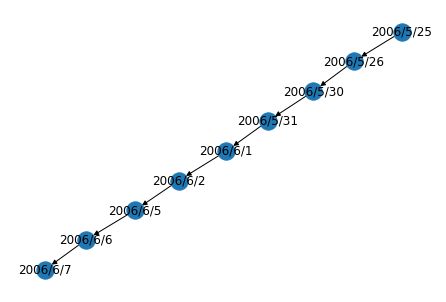

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

goog_graph_1 = nx.DiGraph()

for i in range(8):
    if (goog_lab['Date'][i][5:6] in first_quarter) and (goog_lab['Date'][i+1][5:6] in first_quarter):
        goog_graph_1.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
    
    elif (goog_lab['Date'][i][5:6] in second_quarter) and (goog_lab['Date'][i+1][5:6] in second_quarter):
        goog_graph_1.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
        
    elif (goog_lab['Date'][i][5:6] in third_quarter) and (goog_lab['Date'][i+1][5:6] in third_quarter):
        goog_graph_1.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
        
    elif (goog_lab['Date'][i][5:6] in fourth_quarter) and (goog_lab['Date'][i+1][5:6] in fourth_quarter):
        goog_graph_1.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
    
    else:
        continue
#     goog_graph_1.add_edges_from( [ ( goog_lab['Date'][i] , str(goog_lab['Label'][i] ) ) ] )

# goog_graph_1.add_edges_from( [ ( goog_lab['Date'][8] , str(goog_lab['Label'][8]) ) ] )

# goog_graph.add_edges_from([(1,2)])
pos = nx.kamada_kawai_layout(goog_graph_1)
nx.draw(goog_graph_1,pos,with_labels=True)

In [26]:
'''
Prepping the feature tensor matrix
'''
# 2707 x 8 --> feature tensor size
import torch
'''

[
    ['Open', 'High', 'Low', 'Close', 'Volume', 'KDJ', 'W%R', 'RSI', 'Label'],
    [],
    .
    .
    .
    []
]

'''
print(list(goog_lab.columns[1:10]))
feature_set_=[]
# feature_set_.append(list(goog_lab.iloc[0,1:9])) # for label 0
# feature_set_.append(list(goog_lab.iloc[2,1:9])) # for label 1
# feature_set_.append(list(goog_lab.iloc[3,1:9])) # for label 2
# num_of_rows
for i in range(num_of_rows):
    feature_set_.append(list(goog_lab.iloc[i,1:10]))
# feature_set = torch.tensor(feature_set,requires_grad=True)
feature_set = torch.tensor(feature_set_,dtype=torch.double)
print(feature_set.size())
feature_set = feature_set.double()
print(feature_set)

['Open', 'High', 'Low', 'Close', 'Volume', 'KDJ', 'W%R', 'RSI', 'Label']
torch.Size([2165, 9])
tensor([[ 1.8832e+02,  1.9026e+02,  1.8495e+02,  ..., -9.3664e-04,
          0.0000e+00,  0.0000e+00],
        [ 1.9103e+02,  1.9169e+02,  1.8879e+02,  ..., -7.7436e-01,
          1.8147e+00,  0.0000e+00],
        [ 1.8792e+02,  1.8927e+02,  1.8452e+02,  ..., -9.4869e-01,
          5.6746e+00,  1.0000e+00],
        ...,
        [ 5.2588e+02,  5.3133e+02,  5.2443e+02,  ..., -3.1702e-02,
         -4.2313e+00,  0.0000e+00],
        [ 5.2928e+02,  5.3255e+02,  5.2711e+02,  ..., -9.4167e-01,
          4.6797e+00,  1.0000e+00],
        [ 5.2520e+02,  5.2825e+02,  5.2425e+02,  ..., -1.8159e-01,
          9.1052e-01,  0.0000e+00]], dtype=torch.float64)


In [61]:
print(len(goog_graph.nodes()))
import torch_geometric

goog_graph_geo = torch_geometric.utils.from_networkx(goog_graph)
print(goog_graph_geo)

2165
Data(edge_index=[2, 4276])


In [79]:
goog_graph_geo.x=feature_set
goog_graph_geo.is_directed()

False

In [83]:
# lis = [0,1,2]
goog_lab_tensor_ = list(goog_lab['Label'])
goog_lab_tensor = list(goog_lab['Label'])

# goog_lab_tensor.insert(0,0)
# goog_lab_tensor.insert(1,1)
# goog_lab_tensor.insert(2,2)

goog_lab_tensor = torch.tensor(goog_lab_tensor)
print(goog_lab_tensor.size())
print(goog_lab_tensor.resize(num_of_rows,1))

torch.Size([2165])
tensor([[0],
        [0],
        [1],
        ...,
        [0],
        [1],
        [0]])


In [84]:
goog_lab_tensor__ = list(goog_lab['Label'])
# goog_lab_tensor__.insert(0,0)
# goog_lab_tensor__.insert(1,1)
# goog_lab_tensor__.insert(2,2)
print(len(goog_lab_tensor__))

goog_lab_tensor_prob = []

for i in goog_lab_tensor__:
    if(i==0):
        goog_lab_tensor_prob.append([1,0,0])
    if(i==1):
        goog_lab_tensor_prob.append([0,1,0])
    if(i==2):
        goog_lab_tensor_prob.append([0,0,1])

print(goog_lab_tensor_prob[0:2])

2165
[[1, 0, 0], [1, 0, 0]]


In [85]:
goog_lab_tensor_prob = torch.tensor(goog_lab_tensor_prob)
print(type(goog_lab_tensor_prob))
print(goog_lab_tensor_prob)
print(goog_lab_tensor_prob.size())

# len(goog_lab_tensor_)

# goog_lab_tensor_ = torch.tensor(goog_lab_tensor_)
# print(goog_lab_tensor_.size())
# print(goog_lab_tensor_.resize(1,num_of_rows+3,3))

<class 'torch.Tensor'>
tensor([[1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        ...,
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0]])
torch.Size([2165, 3])


In [96]:
import torch

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.load('data/' + ID + '.pt')
        y = self.labels[ID]

        return X, y

from torch.utils.data import DataLoader

training_set = Dataset(feature_set, goog_lab_tensor_prob)
train_dataloader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=False)

# train_dataloader = DataLoader(feature_set, batch_size=60,shuffle=False)
ip,op = enumerate(train_dataloader)

# print(i for i in enumerate(train_dataloader))

TypeError: can only concatenate str (not "Tensor") to str

In [34]:
# print(goog_lab_tensor_prob.size())
# goog_lab_tensor_prob = goog_lab_tensor_prob.resize(6504)
# print(goog_lab_tensor_prob.size())
# goog_lab_tensor_prob = goog_lab_tensor_prob.resize(2168*3)
# print(goog_lab_tensor_prob.size())
# goog_lab_tensor_prob = goog_lab_tensor_prob.tolist()

torch.Size([2168, 3])
torch.Size([6504])


In [97]:
len(goog_lab_tensor_prob)

2165

In [10]:
# 8 -> 6 -> 3

'''Creation of GCN starts'''

import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
import dgl

# print('gpu') if torch.cuda.is_available else print('cpu')
goog_graph_dgl = dgl.from_networkx(goog_graph)
# print(goog_graph_dgl.num_edges())
goog_graph_dgl.ndata['feature'] = feature_set
# print(goog_graph_dgl)
goog_graph_dgl.ndata['feature'][[0,1]]
print(goog_graph_dgl.ndata['feature'].shape[1])
print(goog_graph_dgl.ndata['feature'].shape[0])

Using backend: pytorch


8
2168


In [11]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        # super(GCN, self).__init__()
        super().__init__()
        self.conv1 = GraphConv(in_feats, hidden_size, weight=True, bias=True)
        self.conv2 = GraphConv(hidden_size, num_classes, weight=True, bias=True)

    def forward(self, goog_graph_dgl, inputs):
        h = self.conv1(goog_graph_dgl, inputs)
        h = torch.relu(h)
        h = self.conv2(goog_graph_dgl, h)
        return h
net = GCN(goog_graph_dgl.ndata['feature'].shape[1], 6, 3)
net.double()

# norm='both', weight=True, bias=True
# 0 , 1 , 2

# inputs = embed.weight
# # print(inputs.size())
# labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
# labels = torch.tensor([0, 1])  # their labels are different

GCN(
  (conv1): GraphConv(in=8, out=6, normalization=both, activation=None)
  (conv2): GraphConv(in=6, out=3, normalization=both, activation=None)
)

In [43]:
# output = net(goog_graph_dgl, feature_set)
# print(output)
import torch
torch.cuda.is_available()

False

In [66]:
# output_ = output.detach()
# print(output_)
# output__ = F.softmax(output_,dim=1)
# print(output__.size())
# print(output__)

# criterion = nn.MSELoss(reduction='mean')
# loss = criterion(output__,goog_lab_tensor_prob)

# 1x2168x3
# resize(1,2168*3)
# [1,1,1,....]

In [65]:
# print(loss)

In [12]:
import itertools

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), feature_set), lr=0.01)
all_logits = []
logp_ = 0
logits_ = 0

for epoch in range(300):
    logits = net(goog_graph_dgl, feature_set)
    all_logits.append(logits.detach())
    logp = F.softmax(logits, dim=1)
#     print(logp.size())
    print(logp)
#     print(goog_lab_tensor_prob.size())
    loss_ = criterion(logp.float(), goog_lab_tensor_prob.float())
#     acc = (logp == goog_lab_tensor).float().mean()

    loss_.type(torch.LongTensor)
    print(loss_)
    
    optimizer.zero_grad()
    loss_.backward()
    optimizer.step()
    
    print('Epoch %d | Loss: %.4f' % (epoch, loss_.item()))
#     print(f'Epoch {epoch} | Loss : {loss.item()} | Acc : {acc}')

tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
tensor(0.4560, grad_fn=<MseLossBackward>)
Epoch 0 | Loss: 0.4560
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
tensor(0.4560, grad_fn=<MseLossBackward>)
Epoch 1 | Loss: 0.4560
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
tensor(0.4560, grad_fn=<MseLossBackward>)
Epoch 2 | Loss: 0.4560
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
tensor(0.4560, grad_fn=<MseLo

In [ ]:
'''
Dummy
'''
for i in range(num_of_rows-1):
    if (goog_lab.iloc[i]['Date'][5:6] in first_quarter) and (goog_lab['Date'][i+1][5:6] in first_quarter):
        goog_graph.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
    
    elif (goog_lab['Date'][i][5:6] in second_quarter) and (goog_lab['Date'][i+1][5:6] in second_quarter):
        goog_graph.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
        
    elif (goog_lab['Date'][i][5:6] in third_quarter) and (goog_lab['Date'][i+1][5:6] in third_quarter):
        goog_graph.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
        
    elif (goog_lab['Date'][i][5:6] in fourth_quarter) and (goog_lab['Date'][i+1][5:6] in fourth_quarter):
        goog_graph.add_edges_from( [ ( goog_lab['Date'][i] , goog_lab['Date'][i+1] ) ] )
    
    else:
        continue
    goog_graph.add_edges_from( [ ( goog_lab['Date'][i] , str(goog_lab['Label'][i]) ) ] )

goog_graph.add_edges_from( [ ( goog_lab['Date'][num_of_rows-1] , str(goog_lab['Label'][num_of_rows-1]) ) ] )

# goog_graph.add_edges_from([(1,2)])

# pos = nx.kamada_kawai_layout(goog_graph)
# nx.draw(goog_graph,pos,with_labels=False)

# PyTorch Geometric

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

goog_lab = pd.read_csv('goog_labeled.csv')
goog_lab, goog_lab_test = train_test_split(goog_lab, test_size=0.2, train_size=0.8, shuffle=False)
print(len(goog_lab))
print(type(goog_lab))
print(len(goog_lab_test))
goog_lab.iterrows()

2165
<class 'pandas.core.frame.DataFrame'>
542


<generator object DataFrame.iterrows at 0x000002759F392EB0>

In [99]:
goog_lab

,Date,Open,High,Low,Close,Volume,KDJ,W%R,RSI,Label
0,2006/5/25,188.315186,190.262527,184.952072,190.257553,16495700,0.999063,-0.000937,0.000000,0
1,2006/5/26,191.032516,191.693222,188.787125,189.442856,7381600,0.225640,-0.774360,1.814697,0
2,2006/5/30,187.917770,189.268982,184.524841,184.768265,8688100,0.051310,-0.948690,5.674591,1
3,2006/5/31,185.692245,187.902878,182.204926,184.708649,16066300,0.439408,-0.560592,1.059616,2
4,2006/6/1,185.563095,190.257553,184.599365,190.073761,12637600,0.967518,-0.032482,-4.365112,0
...,...,...,...,...,...,...,...,...,...,...
2160,2014/12/23,524.118103,531.636780,523.411987,527.688477,2203600,0.519951,-0.480049,-4.688721,1
2161,2014/12/24,527.608948,528.851074,524.138000,525.878418,707800,0.369274,-0.630726,2.810059,2
2162,2014/12/26,525.878418,531.328491,524.426392,531.109680,1043400,0.968298,-0.031702,-4.231262,0
2163,2014/12/29,529.279724,532.551758,527.112671,527.429932,2284800,0.058330,-0.941670,4.679748,1


In [100]:
# [Jan,Feb,March]
# (1,2,3)

# [April,May,Jun]
# (4,5,6)

# [Jul,Aug,Sep]
# (7,8,9)

# [Oct,Nov,Dec]
# (10,11,12)

# Connect graphs based on these relationships [Quarter-wise]
first_quarter = ('1','2','3')
second_quarter = ('4','5','6')
third_quarter = ('7','8','9')
fourth_quarter = ('10','11','12')

list_of_years = []
num_of_rows = len(goog_lab.index)
# pd.unique(goog_lab['Date'])
# for i in range(num_of_rows):
#     if goog_lab['Date'][i][:4] not in list_of_years:
#         list_of_years.append(goog_lab['Date'][i][:4])
#     else:
#         continue
for _ , row in goog_lab.iterrows():
    if row['Date'][:4] not in list_of_years:
        list_of_years.append(row['Date'][:4])
    else:
        continue
print(list_of_years)
# goog_lab['Date'][0][:4]=='2006'

['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']


In [101]:
import networkx as nx
goog_graph = nx.Graph()

# goog_graph.add_nodes_from(['0','1','2'])

In [102]:
for i in range(num_of_rows-1):
    if (goog_lab.iloc[i]['Date'][5:6] in first_quarter) and (goog_lab.iloc[i+1]['Date'][5:6] in first_quarter):
        goog_graph.add_edges_from( [ ( goog_lab.iloc[i]['Date'] , goog_lab.iloc[i+1]['Date'] ) ] )
    
    elif (goog_lab.iloc[i]['Date'][5:6] in second_quarter) and (goog_lab.iloc[i+1]['Date'][5:6] in second_quarter):
        goog_graph.add_edges_from( [ ( goog_lab.iloc[i]['Date'] , goog_lab.iloc[i+1]['Date'] ) ] )
        
    elif (goog_lab.iloc[i]['Date'][5:6] in third_quarter) and (goog_lab.iloc[i+1]['Date'][5:6] in third_quarter):
        goog_graph.add_edges_from( [ ( goog_lab.iloc[i]['Date'] , goog_lab.iloc[i+1]['Date'] ) ] )
        
    elif (goog_lab.iloc[i]['Date'][5:6] in fourth_quarter) and (goog_lab.iloc[i+1]['Date'][5:6] in fourth_quarter):
        goog_graph.add_edges_from( [ ( goog_lab.iloc[i]['Date'] , goog_lab.iloc[i+1]['Date'] ) ] )
    
    else:
        continue
#     goog_graph.add_edges_from( [ ( goog_lab.iloc[i]['Date'] , str(goog_lab.iloc[i]['Label']) ) ] )

# goog_graph.add_edges_from( [ ( goog_lab.iloc[num_of_rows-1]['Date'] , str(goog_lab.iloc[num_of_rows-1]['Label']) ) ] )

# goog_graph.add_edges_from([(1,2)])

# pos = nx.kamada_kawai_layout(goog_graph)
# nx.draw(goog_graph,pos,with_labels=False)

In [103]:
'''
Prepping the feature tensor matrix
'''
# 2707 x 8 --> feature tensor size
import torch
'''

[
    ['Open', 'High', 'Low', 'Close', 'Volume', 'KDJ', 'W%R', 'RSI', 'Label'],
    [],
    .
    .
    .
    []
]

'''
print(list(goog_lab.columns[1:10]))
feature_set_=[]
# feature_set_.append(list(goog_lab.iloc[0,1:9])) # for label 0
# feature_set_.append(list(goog_lab.iloc[2,1:9])) # for label 1
# feature_set_.append(list(goog_lab.iloc[3,1:9])) # for label 2
# num_of_rows
for i in range(num_of_rows):
    feature_set_.append(list(goog_lab.iloc[i,1:10]))
# feature_set = torch.tensor(feature_set,requires_grad=True)
feature_set = torch.tensor(feature_set_,dtype=torch.double)
print(feature_set.size())
feature_set = feature_set.double()
print(feature_set)

['Open', 'High', 'Low', 'Close', 'Volume', 'KDJ', 'W%R', 'RSI', 'Label']
torch.Size([2165, 9])
tensor([[ 1.8832e+02,  1.9026e+02,  1.8495e+02,  ..., -9.3664e-04,
          0.0000e+00,  0.0000e+00],
        [ 1.9103e+02,  1.9169e+02,  1.8879e+02,  ..., -7.7436e-01,
          1.8147e+00,  0.0000e+00],
        [ 1.8792e+02,  1.8927e+02,  1.8452e+02,  ..., -9.4869e-01,
          5.6746e+00,  1.0000e+00],
        ...,
        [ 5.2588e+02,  5.3133e+02,  5.2443e+02,  ..., -3.1702e-02,
         -4.2313e+00,  0.0000e+00],
        [ 5.2928e+02,  5.3255e+02,  5.2711e+02,  ..., -9.4167e-01,
          4.6797e+00,  1.0000e+00],
        [ 5.2520e+02,  5.2825e+02,  5.2425e+02,  ..., -1.8159e-01,
          9.1052e-01,  0.0000e+00]], dtype=torch.float64)


In [104]:
print(len(goog_graph.nodes()))
import torch_geometric

goog_graph_geo = torch_geometric.utils.from_networkx(goog_graph)
print(goog_graph_geo)

2165
Data(edge_index=[2, 4276])


In [105]:
goog_graph_geo.x=feature_set
goog_graph_geo.is_directed()

False

In [106]:
# lis = [0,1,2]
goog_lab_tensor_ = list(goog_lab['Label'])
goog_lab_tensor = list(goog_lab['Label'])

# goog_lab_tensor.insert(0,0)
# goog_lab_tensor.insert(1,1)
# goog_lab_tensor.insert(2,2)

goog_lab_tensor = torch.tensor(goog_lab_tensor)
print(goog_lab_tensor.size())
print(goog_lab_tensor.resize(num_of_rows,1))

torch.Size([2165])
tensor([[0],
        [0],
        [1],
        ...,
        [0],
        [1],
        [0]])


d:\software installers\python_installation\lib\site-packages\torch\_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [107]:
goog_lab_tensor__ = list(goog_lab['Label'])
# goog_lab_tensor__.insert(0,0)
# goog_lab_tensor__.insert(1,1)
# goog_lab_tensor__.insert(2,2)
print(len(goog_lab_tensor__))

goog_lab_tensor_prob = []

for i in goog_lab_tensor__:
    if(i==0):
        goog_lab_tensor_prob.append([1,0,0])
    if(i==1):
        goog_lab_tensor_prob.append([0,1,0])
    if(i==2):
        goog_lab_tensor_prob.append([0,0,1])

print(goog_lab_tensor_prob[0:2])

2165
[[1, 0, 0], [1, 0, 0]]


In [108]:
goog_lab_tensor_prob = torch.tensor(goog_lab_tensor_prob)
print(type(goog_lab_tensor_prob))
print(goog_lab_tensor_prob)
print(goog_lab_tensor_prob.size())

# len(goog_lab_tensor_)

# goog_lab_tensor_ = torch.tensor(goog_lab_tensor_)
# print(goog_lab_tensor_.size())
# print(goog_lab_tensor_.resize(1,num_of_rows+3,3))

<class 'torch.Tensor'>
tensor([[1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        ...,
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0]])
torch.Size([2165, 3])


In [ ]:
import torch

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.load('data/' + ID + '.pt')
        y = self.labels[ID]

        return X, y

from torch.utils.data import DataLoader

training_set = Dataset(feature_set, goog_lab_tensor_prob)
train_dataloader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=False)

# train_dataloader = DataLoader(feature_set, batch_size=60,shuffle=False)
ip,op = enumerate(train_dataloader)

# print(i for i in enumerate(train_dataloader))

In [ ]:
'''
DGL GCN
'''

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        # super(GCN, self).__init__()
        super().__init__()
        self.conv1 = GraphConv(in_feats, hidden_size, weight=True, bias=True)
        self.conv2 = GraphConv(hidden_size, num_classes, weight=True, bias=True)

    def forward(self, goog_graph_dgl, inputs):
        h = self.conv1(goog_graph_dgl, inputs)
        h = torch.relu(h)
        h = self.conv2(goog_graph_dgl, h)
        return h
net = GCN(goog_graph_dgl.ndata['feature'].shape[1], 6, 3)
net.double()

# norm='both', weight=True, bias=True
# 0 , 1 , 2

# inputs = embed.weight
# # print(inputs.size())
# labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
# labels = torch.tensor([0, 1])  # their labels are different

In [118]:
'''
PyT Geometric GCN
'''

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(9, 7)
        self.conv2 = GCNConv(7, 5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.softmax(x, dim=1)

In [120]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.double()
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
a=0
model.train()
for epoch in range(10):
    optimizer.zero_grad()
    out = model(goog_graph_geo)
    a=out
    print(out)
#     loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()

tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
tensor([[0., 0., 0., 1., 0.],
  

In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print('Accuracy: {:.4f}'.format(acc))

In [ ]:
from torch.utils import data

class GraphDataset(data.Dataset):

    def __init__(self,graphData):
        self.graphDataFame = graphData

    def __len__(self):
        return len(self.graphDataFame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        nodeId = self.graphDataFame.iloc[idx]['Date']
        nodeFeature = np.array(self.graphDataFame.iloc[idx].drop(['Date','Label'])).astype(np.float32)
        nodeLabel = np.array(self.gr
nodeLabel = np.array(self.graphDataFame.iloc[idx]['Label'])      

        return {'nodeId': nodeId,
            'nodeFeature': torch.tensor(nodeFeature.reshape([-1,1])),
            'nodeLabel': torch.tensor(nodeLabel, dtype = torch.long)}
                             
train_test_split ---> datsetobject ---> dataloader
total 100 datapint
with 10 batchsize
                             
https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/nn/attention/stgcn.html
https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/index.html